In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
!pip install tf-nightly-2.0-preview


ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [200]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [338]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, time_span, slope=0):
    return np.where(time < 600, slope * time, (600-(time-600)) * slope) 
    # return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    # return np.where(season_time < 0.4,
    #                 np.cos(season_time * 2 * np.pi),
    #                 np.sin(season_time * 2 * np.pi))
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time_span = 4*365
time = np.arange(time_span + 1, dtype="float32")
baseline = 10
series = trend(time, time_span, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, time_span, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
mv_avg = 20
time_train = time[mv_avg:split_time]
x_train = series[mv_avg:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

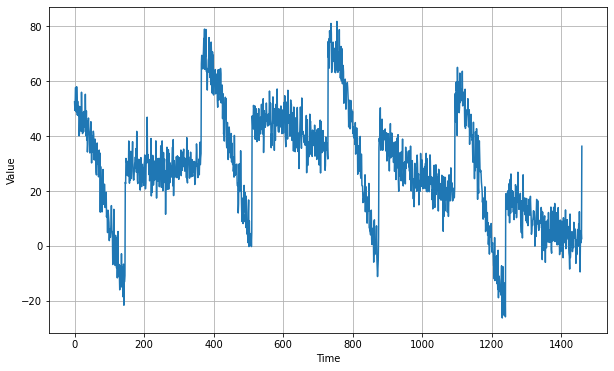

In [270]:

plt.figure(figsize=(10, 6))

plot_series(time, series)
# plot_series(time_valid, results)

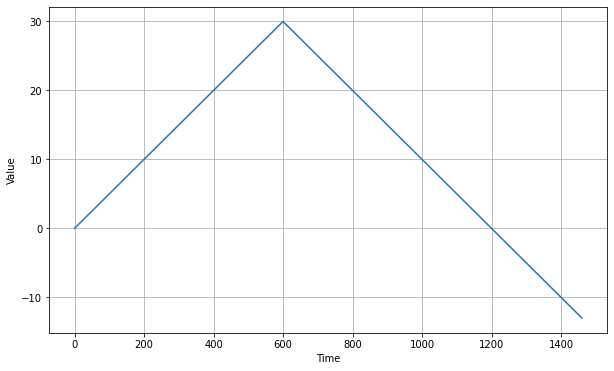

In [271]:
plt.figure(figsize=(10, 6))

plot_series(time, trend(time, time_span, slope))

In [272]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [273]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

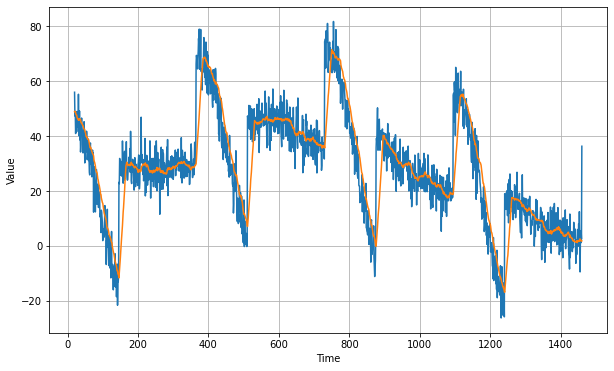

In [333]:
moving_avg = moving_average_forecast(series, mv_avg)

plt.figure(figsize=(10, 6))
plot_series(time[mv_avg:], series[mv_avg:])
plot_series(time[mv_avg:], moving_avg)

In [275]:
split_time = 1000
time_train = time[mv_avg:split_time]
x_train_mov = series[mv_avg:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [276]:
dataset_mov = windowed_dataset(x_train_mov, window_size, batch_size, shuffle_buffer_size)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [324]:
def model_ts(window_size):
  input = tf.keras.layers.Input(shape=(window_size))
  input_mov = tf.keras.layers.Input(shape=(window_size))
  x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(input)
  y = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(input_mov)

  y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(y)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)
  x = tf.keras.layers.Concatenate()([x,y])
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
  x = tf.keras.layers.Dense(1)(x)
  x = tf.keras.layers.Lambda(lambda x: x * 100.0)(x)
  return tf.keras.Model([input, input_mov], x)

In [325]:
model = model_ts(window_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 20, 1)        0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 20, 1)        0           input_2[0][0]                    
______________________________________________________________________________________________

In [326]:
train_x = []
train_y = []
for x,y in dataset:
  a = x.numpy()
  b = y.numpy()
  for i in range(0,len(a)):
    train_x.append(a[i])
    train_y.append(b[i])

mov_x = []
mov_y = []
for x,y in dataset_mov:
  a = x.numpy()
  b = y.numpy()
  for i in range(0,len(a)):
    mov_x.append(a[i])
    mov_y.append(b[i])

In [327]:
train_x = np.array(train_x)
mov_x = np.array(mov_x)
train_y = np.array(train_y)

print(np.shape(train_x))
print(np.shape(mov_x))
print(np.shape(train_y))

(960, 20)
(960, 20)
(960,)


In [328]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(x=[train_x, mov_x], y=train_y ,epochs=10)

Epoch 1/10
30/30 [==============================] - 6s 10ms/step - loss: 3102.1444 - mae: 43.3617
Epoch 2/10
30/30 [==============================] - 0s 10ms/step - loss: 168.3890 - mae: 9.6318
Epoch 3/10
30/30 [==============================] - 0s 10ms/step - loss: 73.7146 - mae: 6.3440
Epoch 4/10
30/30 [==============================] - 0s 10ms/step - loss: 78.8716 - mae: 6.8065
Epoch 5/10
30/30 [==============================] - 0s 10ms/step - loss: 69.1629 - mae: 6.1846
Epoch 6/10
30/30 [==============================] - 0s 10ms/step - loss: 57.0907 - mae: 5.8635
Epoch 7/10
30/30 [==============================] - 0s 10ms/step - loss: 63.0248 - mae: 5.9866
Epoch 8/10
30/30 [==============================] - 0s 10ms/step - loss: 103.6585 - mae: 7.9646
Epoch 9/10
30/30 [==============================] - 0s 10ms/step - loss: 71.0249 - mae: 6.5470
Epoch 10/10
30/30 [==============================] - 0s 10ms/step - loss: 56.4141 - mae: 5.9029


<h4> Auto-regressive prediction </h4>

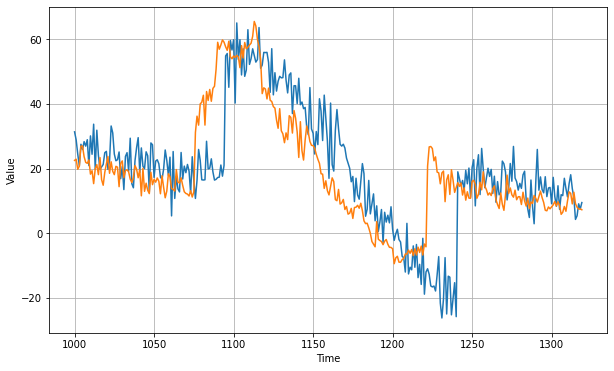

In [336]:
forecast = []
results = []
x = series[1000-window_size:][:320]
z = mov_x[980:1300]
for time in range(1000,1320):
  out = model.predict([series[time:time + window_size][np.newaxis],moving_avg[time-1000:time-1000 + window_size][np.newaxis]])[0][0]
  forecast.append(out)
  y = list(x)
  y.append(out)
  x = np.array(y)


plt.figure(figsize=(10, 6))

plot_series(time_valid[:320], x_valid[:320])
plot_series(time_valid[:320], forecast)

<h4> Single point prediction </h4> 

In [334]:
len(series)

1461

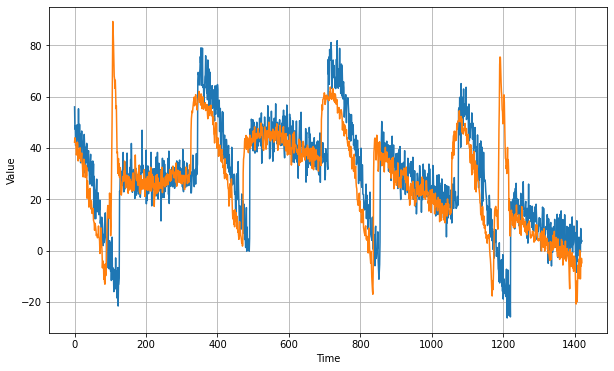

In [335]:
forecast = []
results = []
for time in range(20,len(series) - window_size):
  forecast.append(model.predict([series[time:time + window_size][np.newaxis],moving_avg[time-20:time-20 + window_size][np.newaxis]]))

temp = forecast
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(np.arange(1421), series[20:1441])
plot_series(np.arange(1421), np.array(temp)[:, 0, 0])

<h4> Changing moving avg </h4>

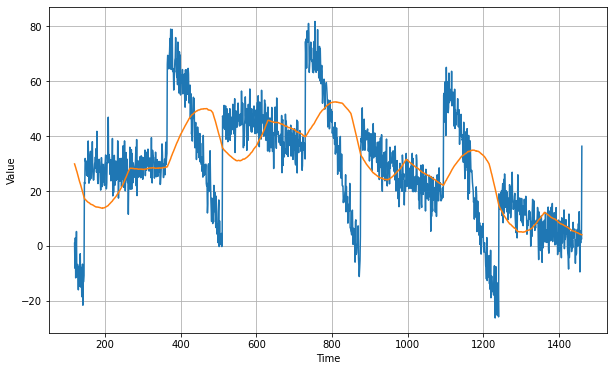

In [339]:
moving_avg = moving_average_forecast(series, 120)

plt.figure(figsize=(10, 6))
plot_series(time[120:], series[120:])
plot_series(time[120:], moving_avg)

In [340]:
forecast = []
results = []
for time in range(120,len(series) - window_size):
  forecast.append(model.predict([series[time:time + window_size][np.newaxis],moving_avg[time-120:time-120 + window_size][np.newaxis]]))

temp = forecast
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

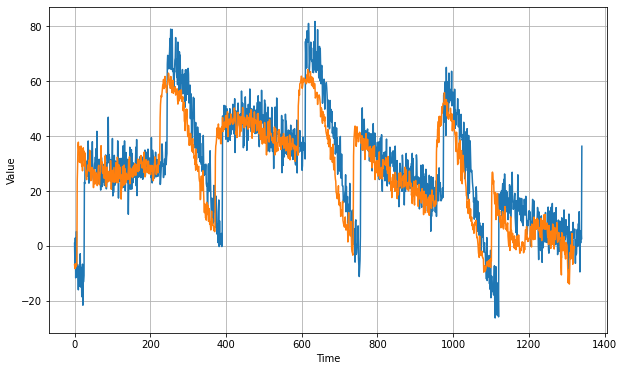

In [343]:
# 120 window size
plt.figure(figsize=(10, 6))

plot_series(np.arange(1341), series[120:])
plot_series(np.arange(1321), np.array(temp)[:, 0, 0])

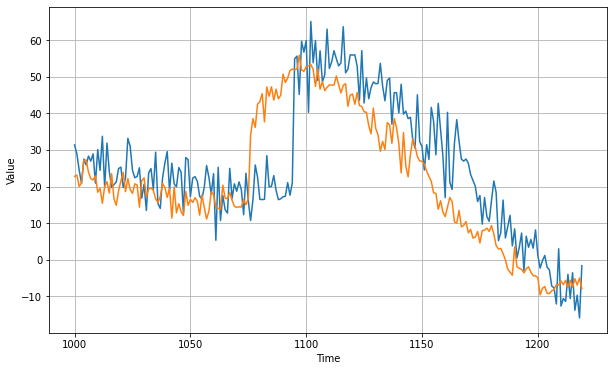

In [345]:
forecast = []
results = []
x = series[1000-window_size:][:220]
z = np.array(moving_avg[880:])
for time in range(1000,1220):
  out = model.predict([series[time:time + window_size][np.newaxis],z[time-1000:time-1000 + window_size][np.newaxis]])[0][0]
  forecast.append(out)
  y = list(x)
  y.append(out)
  x = np.array(y)


plt.figure(figsize=(10, 6))

plot_series(time_valid[:220], x_valid[:220])
plot_series(time_valid[:220], forecast)